In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from tensorflow.keras import datasets, layers, utils, Sequential, Model
import matplotlib.pyplot as plt

from utils import *

# Utils

In [2]:
(train_x, train_y), (test_x, test_y) = datasets.mnist.load_data()
train_x = train_x.reshape([train_x.shape[0], -1]) / 255.
test_x = test_x.reshape([test_x.shape[0], -1]) / 255.

train_y = utils.to_categorical(train_y, 10)
test_y = utils.to_categorical(test_y, 10)

In [3]:
print(train_x.shape, test_x.shape)

(60000, 784) (10000, 784)


# Model creation

In [5]:
class NN(Model):
    def __init__(self, sparsity, inputs_shape= 28 * 28):
        super(NN, self).__init__()
        
        self.inputs_shape = inputs_shape
        self.is_train_on_sparse = False
        self.sparsity = sparsity
        
        self.fc1 = layers.Dense(512, activation="relu", kernel_initializer='glorot_uniform')
        self.fc2 = layers.Dense(256, activation="relu", kernel_initializer='glorot_uniform')
        self.fc3 = layers.Dense(128, activation="relu", kernel_initializer='glorot_uniform')
        self.fc4 = layers.Dense(10, activation="softmax", kernel_initializer='glorot_uniform')
        
        # All DSD layers except last layer.
        self.is_dsd_layers = [True]*(len(self.layers) - 1) + [False]
        
    def reset_masks(self):
        self.masks = []
        
        for layer in self.layers:        
            w, b = layer.get_weights()
            self.masks.append([tf.ones_like(w), tf.ones_like(b)])
        
        return self.masks
    
    def prune_layers(self):
    
        for i, (layer, (w, b)) in enumerate(zip(self.layers, self.masks)):
            
            # This return a Tensor while get_weights() return np.array.
            curr_wb = layer.weights
            
            # Get pruning masks
            # Weight
            qk = tfp.stats.percentile(tf.math.abs(curr_wb[0]), q = self.sparsity * 100)
            mask_w = tf.where(tf.math.abs(curr_wb[0]) < qk, 0., 1.)

            # Bias
            qk = tfp.stats.percentile(tf.math.abs(curr_wb[1]), q = self.sparsity * 100)
            mask_b = tf.where(tf.math.abs(curr_wb[1]) < qk, 0., 1.)
            
            # Keep track of masks for "Training on Sparse" step.
            self.masks[i][0] = mask_w
            self.masks[i][1] = mask_b
            
            # Apply masks to each weights/biases layer.
            curr_wb[0].assign(curr_wb[0] * mask_w)
            curr_wb[1].assign(curr_wb[1] * mask_b)
            
            layer.set_weights((curr_wb[0].numpy(), curr_wb[1].numpy()))
            
    def stop_gradients(self, layer_idx, masks):
        
        # Get layer weights/biases at a given index.
        layer = self.layers[layer_idx]
        wb = layer.weights
        
        # Apply masks to each weights/biases at a given layer
        wb[0].assign(wb[0] * self.masks[layer_idx][0])
        wb[1].assign(wb[1] * self.masks[layer_idx][1])
                
    def call(self, x):
        
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if self.is_train_on_sparse and self.is_dsd_layers[i]:
                self.stop_gradients(i, self.masks)
        return x

    def build_model(self):
        x = layers.Input(shape=self.inputs_shape)
        return Model(inputs=[x], outputs = self.call(x))         

In [6]:
sparsity_global_variable = 0.5

model = NN(sparsity=sparsity_global_variable)
model.build_model()#.summary()
model.reset_masks()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# I/ Training

In [7]:
model.fit(train_x, train_y, epochs=1, workers=1)

1875/1875 [==============================] - 12s 6ms/step - loss: 0.3357 - accuracy: 0.8969


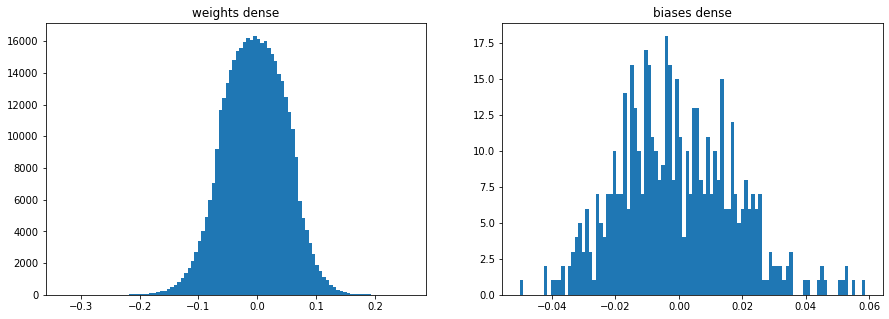

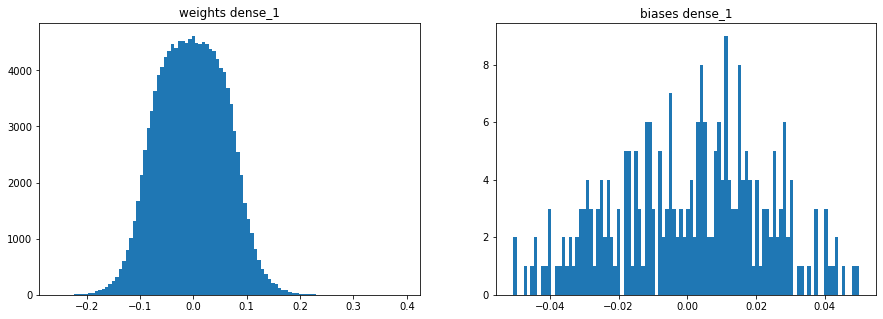

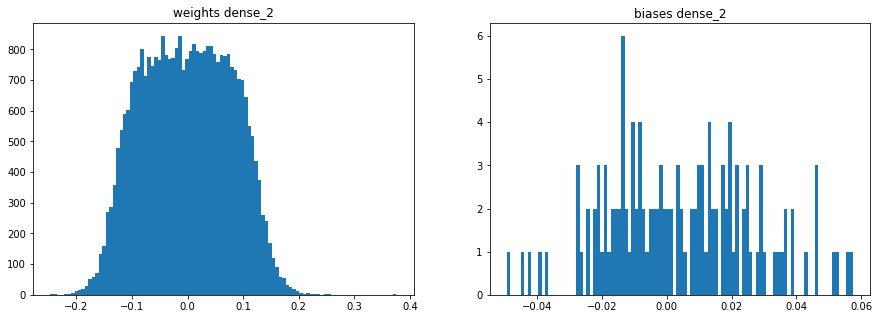

In [8]:
plot_wb(model)

# II/ Prune the network

In [9]:
model.prune_layers()

InvalidArgumentError: cannot compute Mul as input #1(zero-based) was expected to be a float tensor but is a int32 tensor [Op:Mul]

In [ ]:
plot_wb(model)

In [ ]:
wb_non_zero_percentage(model)

# III/ Train on Sparse

In [ ]:
model.is_train_on_sparse = True

In [ ]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(train_x, train_y, epochs=1)

In [ ]:
plot_wb(model)

In [ ]:
wb_non_zero_percentage(model)